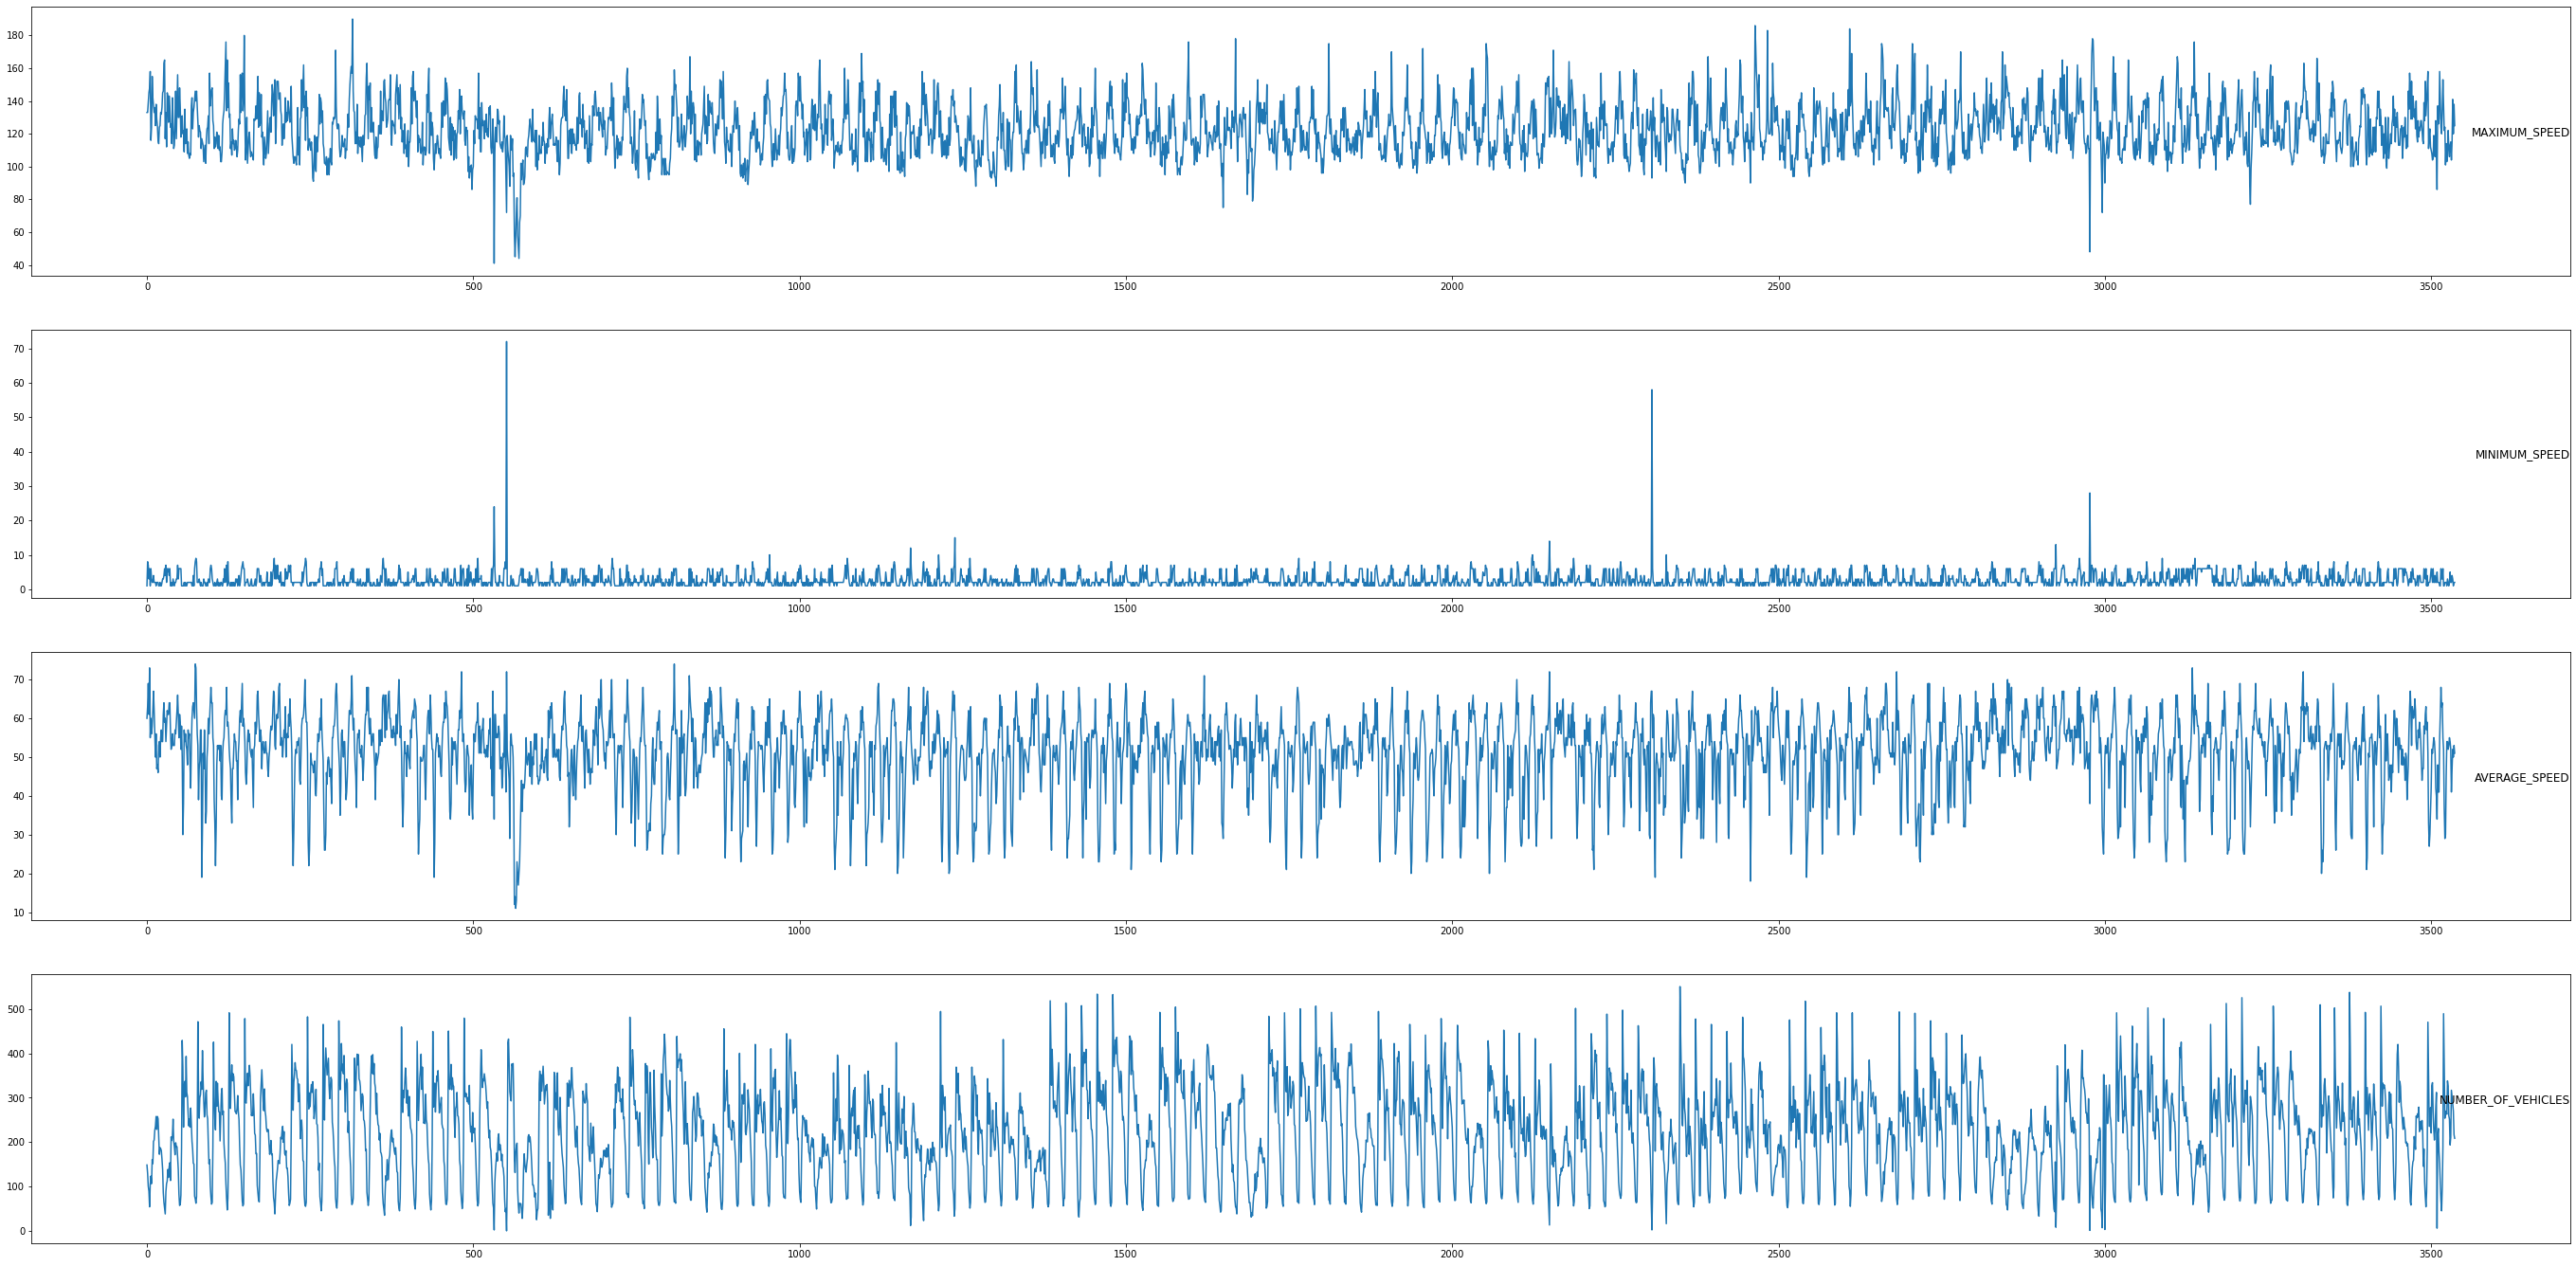

In [19]:
from pandas import read_excel
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot

# load dataset
dataset = read_excel(r'C:\sxk990_6ay.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure(figsize=(48, 24))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [20]:
# prepare data for lstm
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [22]:
# specify the number of lag and Step hours
n_hours = 6
n_steps = 3
n_features = 4
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),...,var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var3(t),var3(t+1),var3(t+2)
6,133.0,1.0,60.0,149.0,133.0,8.0,63.0,130.0,139.0,7.0,...,6.0,73.0,55.0,158.0,1.0,55.0,105.0,60.0,56.0,58.0
7,133.0,8.0,63.0,130.0,139.0,7.0,69.0,101.0,145.0,3.0,...,1.0,55.0,105.0,116.0,6.0,60.0,124.0,56.0,58.0,62.0
8,139.0,7.0,69.0,101.0,145.0,3.0,61.0,90.0,148.0,6.0,...,6.0,60.0,124.0,124.0,3.0,56.0,107.0,58.0,62.0,67.0
9,145.0,3.0,61.0,90.0,148.0,6.0,73.0,55.0,158.0,1.0,...,3.0,56.0,107.0,155.0,2.0,58.0,161.0,62.0,67.0,62.0
10,148.0,6.0,73.0,55.0,158.0,1.0,55.0,105.0,116.0,6.0,...,2.0,58.0,161.0,142.0,2.0,62.0,152.0,67.0,62.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,103.0,1.0,54.0,263.0,108.0,3.0,54.0,338.0,122.0,2.0,...,2.0,55.0,252.0,113.0,5.0,54.0,194.0,52.0,41.0,47.0
3531,108.0,3.0,54.0,338.0,122.0,2.0,52.0,326.0,112.0,1.0,...,5.0,54.0,194.0,115.0,2.0,52.0,211.0,41.0,47.0,52.0
3532,122.0,2.0,52.0,326.0,112.0,1.0,53.0,260.0,106.0,2.0,...,2.0,52.0,211.0,104.0,2.0,41.0,317.0,47.0,52.0,50.0
3533,112.0,1.0,53.0,260.0,106.0,2.0,55.0,252.0,113.0,5.0,...,2.0,41.0,317.0,115.0,4.0,47.0,303.0,52.0,50.0,53.0


In [23]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [24]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_steps:]
test_X, test_y = test[:, :n_obs], test[:, -n_steps:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, len(test_X))

(2117, 24) (2117, 3) (1412, 24) (1412, 3) 1412


In [25]:
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM

from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from matplotlib import pyplot

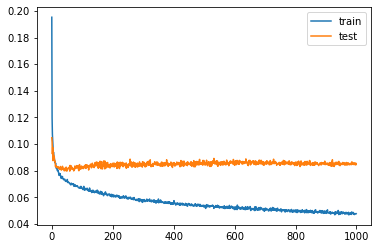

In [29]:
# design network
model = Sequential()
model.add(Dense(200, activation='relu', input_dim = (n_obs)))
model.add(Dropout(0.15))
model.add(Dense(100, activation='relu' ))
model.add(Dropout(0.15))
model.add(Dense(100, activation='relu' ))
model.add(Dense(n_steps))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
pred_train_y = model.predict(train_X)
#train_X = train_X.reshape((train_X.shape[0], n_obs))

In [ ]:
# invert scaling for forecast
pred_train_y = concatenate((train_X[:, -n_obs:], pred_train_y), axis=1)
pred_train_y = scaler.inverse_transform(pred_train_y)
pred_train_y = pred_train_y[:,-n_steps:]

In [ ]:
# invert scaling for actual
#train_y = train_y.reshape((len(train_y), n_steps))
train_y = concatenate((train_X[:, -n_obs:], train_y), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,-n_steps:]

In [ ]:
# make a prediction
pred_test_y = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], n_obs))

# invert scaling for forecast
pred_test_y = concatenate(( test_X[:, -n_obs:], pred_test_y), axis=1)
pred_test_y = scaler.inverse_transform(pred_test_y)
pred_test_y = pred_test_y[:,-n_steps:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_y = concatenate((test_X[:, -n_obs:], test_y), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,-n_steps:]

In [ ]:
# calculate RMSE
rmse_train = sqrt(mean_squared_error(train_y, pred_train_y))
print("Train data score: %.2f RMSE" % rmse_train)

rmse_test = sqrt(mean_squared_error(test_y, pred_test_y))
print("Test data score: %.2f RMSE" % rmse_test)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_y, pred_train_y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_y, pred_test_y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_y[:,0], pred_test_y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_y[:,1], pred_test_y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_y[:,2], pred_test_y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

In [ ]:
mdape_tr = np.median((np.abs(np.subtract(train_y, pred_train_y)/ train_y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_y, pred_test_y)/ test_y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_y, pred_train_y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_y, pred_test_y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

In [ ]:
from sklearn.metrics import mean_absolute_error
e_tr = train_y - pred_train_y
scale = mean_absolute_error(train_y[1:], train_y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_y - pred_test_y
scale = mean_absolute_error(test_y[1:], test_y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)


In [ ]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')